In [1]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt



Matplotlib is building the font cache; this may take a moment.


In [2]:
#page replacement
def fifo(pages, frames):
    memory, faults = [], 0
    for page in pages:
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                memory.pop(0)
                memory.append(page)
    return faults

def lru(pages, frames):
    memory, faults = [], 0
    for i, page in enumerate(pages):
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                lru_page = min(memory, key=lambda p: pages[:i][::-1].index(p))
                memory[memory.index(lru_page)] = page
    return faults

def optimal(pages, frames):
    memory, faults = [], 0
    for i, page in enumerate(pages):
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                future = pages[i+1:]
                indices = [future.index(p) if p in future else float('inf') for p in memory]
                memory.pop(indices.index(max(indices)))
                memory.append(page)
    return faults


In [20]:
import random
import pandas as pd

def generate_sequence(n_pages, length, locality):
    seq = []
    for _ in range(length):
        if random.random() < locality and seq:
            seq.append(random.choice(seq[-5:]))  # reuse recent pages
        else:
            seq.append(random.randint(0, n_pages - 1))
    return seq

def fifo(pages, frames):
    memory, faults = [], 0
    for page in pages:
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                memory.pop(0)
                memory.append(page)
    return faults

def lru(pages, frames):
    memory, faults = [], 0
    for i, page in enumerate(pages):
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                lru_page = min(memory, key=lambda p: pages[:i][::-1].index(p))
                memory[memory.index(lru_page)] = page
    return faults

def optimal(pages, frames):
    memory, faults = [], 0
    for i, page in enumerate(pages):
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                future = pages[i+1:]
                indices = [future.index(p) if p in future else float('inf') for p in memory]
                memory.pop(indices.index(max(indices)))
                memory.append(page)
    return faults

# --- Balanced Dataset Generation ---
data = []
target_counts = {"FIFO": 0, "LRU": 0, "Optimal": 0}
target_each = 200  # total 600 samples (200 of each)

while min(target_counts.values()) < target_each:
    n_pages = random.randint(5, 30)
    frames = random.randint(2, 10)
    seq_len = random.randint(20, 100)
    locality = random.uniform(0.1, 0.9)
    seq = generate_sequence(n_pages, seq_len, locality)

    f = fifo(seq, frames)
    l = lru(seq, frames)
    o = optimal(seq, frames)
    best = min([("FIFO", f), ("LRU", l), ("Optimal", o)], key=lambda x: x[1])[0]

    # Only add if we still need more of that algorithm
    if target_counts[best] < target_each:
        data.append([n_pages, frames, locality, seq_len, f, l, o, best])
        target_counts[best] += 1

df = pd.DataFrame(data, columns=[
    "num_pages", "memory_size", "locality", "sequence_len",
    "fifo_faults", "lru_faults", "optimal_faults", "best_algo"
])

print("✅ Dataset Created with Balanced Classes:")
print(df["best_algo"].value_counts())
df.head()



✅ Dataset Created with Balanced Classes:
best_algo
Optimal    200
FIFO       200
LRU        200
Name: count, dtype: int64


,num_pages,memory_size,locality,sequence_len,fifo_faults,lru_faults,optimal_faults,best_algo
0,10,6,0.449813,74,21,30,14,Optimal
1,12,3,0.627999,65,26,38,21,Optimal
2,22,3,0.733899,50,17,35,12,Optimal
3,17,5,0.445196,74,33,40,23,Optimal
4,28,5,0.193529,77,50,66,38,Optimal


In [24]:
X = df[["num_pages", "memory_size", "locality", "sequence_len"]]
y = df["best_algo"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("✅ Model Accuracy:", accuracy_score(y_test, y_pred))

joblib.dump(model, "best_algo_model.pkl")
joblib.dump(le, "label_encoder.pkl")
print("✅ Model saved as best_algo_model.pkl")


✅ Model Accuracy: 0.6916666666666667
✅ Model saved as best_algo_model.pkl


In [27]:
model = joblib.load("best_algo_model.pkl")
le = joblib.load("label_encoder.pkl")




In [30]:
import pandas as pd

# Direct input values
num_pages = 20
memory_size = 4
locality = 0.6
sequence_len = 80

test_input = pd.DataFrame([[num_pages, memory_size, locality, sequence_len]],
                          columns=["num_pages", "memory_size", "locality", "sequence_len"])

pred = model.predict(test_input)
pred_algo = le.inverse_transform(pred)[0]

print("🧠 Predicted Best Algorithm:", pred_algo)

🧠 Predicted Best Algorithm: Optimal


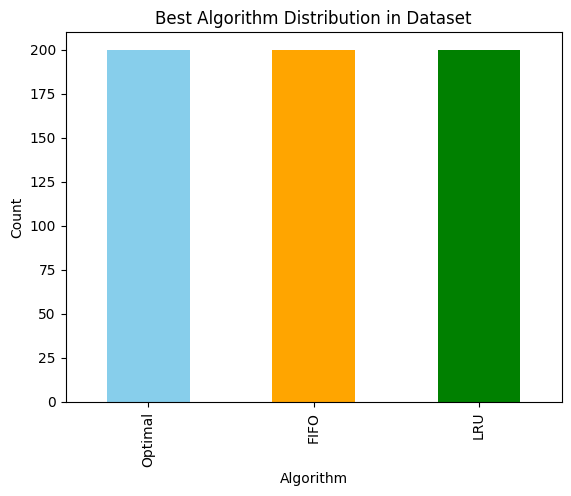

In [33]:
df["best_algo"].value_counts().plot(kind="bar", color=["skyblue","orange","green"])
plt.title("Best Algorithm Distribution in Dataset")
plt.xlabel("Algorithm")
plt.ylabel("Count")
plt.show()


In [35]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the saved model and encoder
model = joblib.load("best_algo_model.pkl")
le = joblib.load("label_encoder.pkl")

# Create input widgets
num_pages = widgets.IntSlider(value=10, min=5, max=50, step=1, description="No. of Pages:")
memory_size = widgets.IntSlider(value=3, min=2, max=10, step=1, description="Frames:")
locality = widgets.FloatSlider(value=0.5, min=0.1, max=0.9, step=0.1, description="Locality:")
sequence_len = widgets.IntSlider(value=50, min=10, max=200, step=10, description="Seq Length:")

# Output area
out = widgets.Output()

def predict_algo(change):
    with out:
        clear_output()
        test_input = [[num_pages.value, memory_size.value, locality.value, sequence_len.value]]
        pred = model.predict(test_input)
        pred_algo = le.inverse_transform(pred)[0]
        print(f"🧠 Predicted Best Algorithm: {pred_algo}")

# Button to trigger prediction
button = widgets.Button(description="Predict Best Algorithm", button_style='success')
button.on_click(predict_algo)

# Display everything
display(num_pages, memory_size, locality, sequence_len, button, out)


IntSlider(value=10, description='No. of Pages:', max=50, min=5)

IntSlider(value=3, description='Frames:', max=10, min=2)

FloatSlider(value=0.5, description='Locality:', max=0.9, min=0.1)

IntSlider(value=50, description='Seq Length:', max=200, min=10, step=10)

Button(button_style='success', description='Predict Best Algorithm', style=ButtonStyle())

Output()